# Playground for influence based acquisition with GPs

In [ ]:
%matplotlib inline
import sys
import GPyOpt
import numpy as np
from shinyutils import MatWrap as mw

from infopt.gpinfacq import GPInfAcq
from infopt.gpinfacq_mcmc import GPInfAcq_MCMC

## Hyperparameters

In [ ]:
INITIAL_POINTS = 5
EXPLORATION_WEIGHT = 2
MAX_ITER = 20
MCMC = True
OBJ = "forrester"  # forrester / sixhump

## Objective function

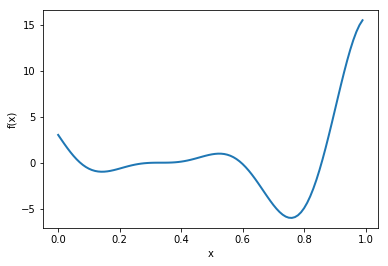

In [ ]:
if OBJ == "forrester":
    f_true = GPyOpt.objective_examples.experiments1d.forrester(sd=0)
    f_noisy = GPyOpt.objective_examples.experiments1d.forrester(sd=1)
    bounds = [{"name": "var_1", "type": "continuous", "domain": (0, 1)}]
elif OBJ == "sixhump":
    f_true = GPyOpt.objective_examples.experiments2d.sixhumpcamel(sd=0)
    f_noisy = GPyOpt.objective_examples.experiments2d.sixhumpcamel(sd=1)
    bounds = [
        {"name": "var_1", "type": "continuous", "domain": f_true.bounds[0]},
        {"name": "var_2", "type": "continuous", "domain": f_true.bounds[1]},
    ]

f_true.plot()
f_min = f_true.fmin

## LCB Acquisition

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


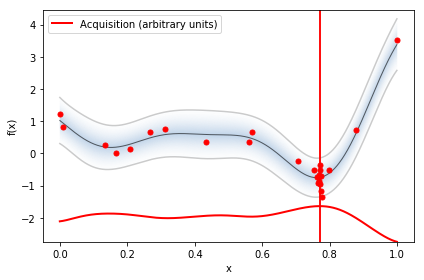

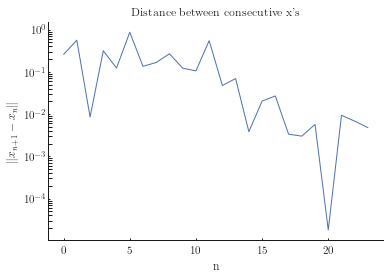

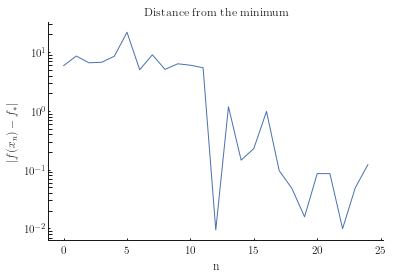

In [ ]:
objective = GPyOpt.core.task.SingleObjective(f_noisy.f)
space = GPyOpt.Design_space(space=bounds)
if MCMC:
    model = GPyOpt.models.GPModel_MCMC(exact_feval=False, verbose=False)
else:
    model = GPyOpt.models.GPModel(exact_feval=False, ARD=False, verbose=False)
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design(
    "random", space, INITIAL_POINTS
)
if MCMC:
    lcb_acq = GPyOpt.acquisitions.AcquisitionLCB_MCMC(
        model, space, acq_optimizer, exploration_weight=EXPLORATION_WEIGHT
    )
else:
    lcb_acq = GPyOpt.acquisitions.AcquisitionLCB(
        model, space, acq_optimizer, exploration_weight=EXPLORATION_WEIGHT
    )
lcb_eval = GPyOpt.core.evaluators.Sequential(lcb_acq)
lcb_bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, lcb_acq, lcb_eval, initial_design
)

lcb_bo.run_optimization(max_iter=MAX_ITER)

lcb_bo.plot_acquisition()

mw.configure(context="notebook")
fig = mw.plt().figure()
ax = fig.add_subplot(111)
diffs = np.linalg.norm(lcb_bo.X[1:] - lcb_bo.X[:-1], axis=1)
ax.semilogy(diffs)
ax.set_ylabel("$\|x_{n+1} - x_n\|$")
ax.set_xlabel("n")
_ = ax.set_title("Distance between consecutive x's")

fig = mw.plt().figure()
ax = fig.add_subplot(111)
diffs = np.abs(f_true.f(lcb_bo.X)[:, 0] - f_min)
ax.semilogy(diffs)
ax.set_ylabel("$|f(x_n) - f_*|$")
ax.set_xlabel("n")
_ = ax.set_title("Distance from the minimum")

## Influence Acquisition

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


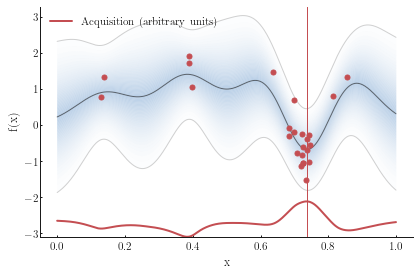

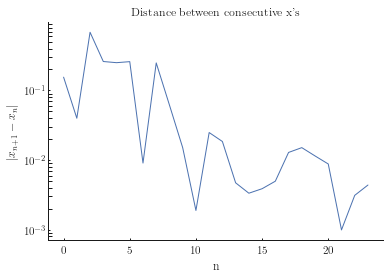

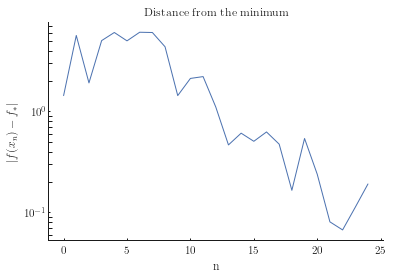

In [ ]:
objective = GPyOpt.core.task.SingleObjective(f_noisy.f)
space = GPyOpt.Design_space(space=bounds)
if MCMC:
    model = GPyOpt.models.GPModel_MCMC(exact_feval=False, verbose=False)
else:
    model = GPyOpt.models.GPModel(exact_feval=False, ARD=False, verbose=False)
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design(
    "random", space, INITIAL_POINTS
)
if MCMC:
    inf_acq = GPInfAcq_MCMC(
        model, space, acq_optimizer, exploration_weight=EXPLORATION_WEIGHT
    )
else:
    inf_acq = GPInfAcq(
        model, space, acq_optimizer, exploration_weight=EXPLORATION_WEIGHT
    )
inf_eval = GPyOpt.core.evaluators.Sequential(inf_acq)
inf_bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, inf_acq, inf_eval, initial_design
)

inf_bo.run_optimization(max_iter=MAX_ITER)

inf_bo.plot_acquisition()

fig = mw.plt().figure()
ax = fig.add_subplot(111)
diffs = np.linalg.norm(inf_bo.X[1:] - inf_bo.X[:-1], axis=1)
ax.semilogy(diffs)
ax.set_ylabel("$|x_{n+1} - x_n|$")
ax.set_xlabel("n")
_ = ax.set_title("Distance between consecutive x's")

fig = mw.plt().figure()
ax = fig.add_subplot(111)
diffs = np.abs(f_true.f(inf_bo.X)[:, 0] - f_min)
ax.semilogy(diffs)
ax.set_ylabel("$|f(x_n) - f_*|$")
ax.set_xlabel("n")
_ = ax.set_title("Distance from the minimum")